Number of rows before drop: 119
Number of rows after drop: 119
Number of columns in the dataframe: 742


/home/aleksander.kolodziej@A4BEE.ad/Desktop/EKG_PPG_BP/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 500: loss = 20.1601, val_loss = 33.3360
Epoch 1000: loss = 11.2914, val_loss = 7.6125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Epoch 500: loss = 15.3579, val_loss = 30.5589
Epoch 1000: loss = 11.1374, val_loss = 8.4626
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Epoch 500: loss = 16.7362, val_loss = 38.0168
Epoch 1000: loss = 14.9889, val_loss = 20.2851
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Epoch 500: loss = 17.1807, val_loss = 39.3190
Epoch 1000: loss = 12.5315, val_loss = 8.1349
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Epoch 500: loss = 16.4758, val_loss = 35.3699
Epoch 1000: loss = 10.7921, val_loss = 8.6782
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


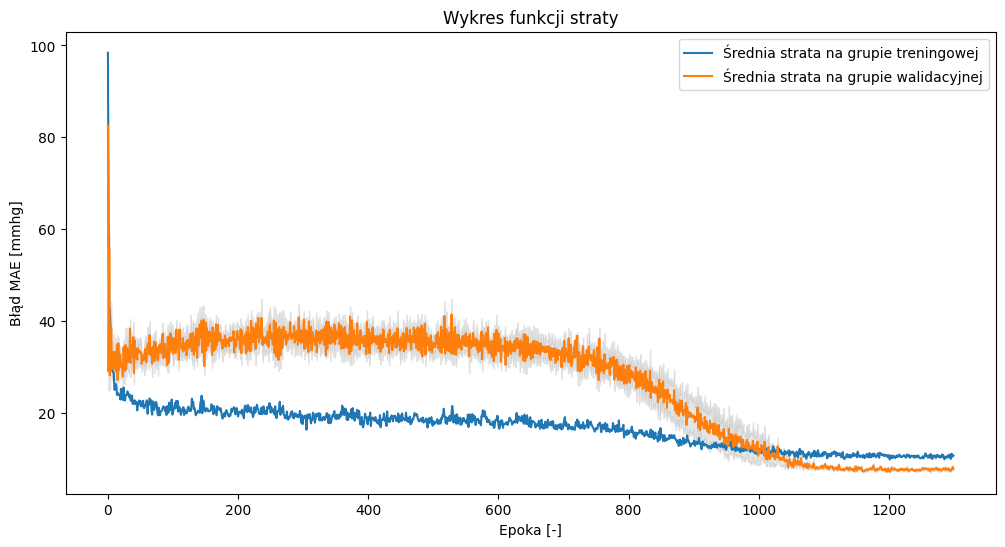

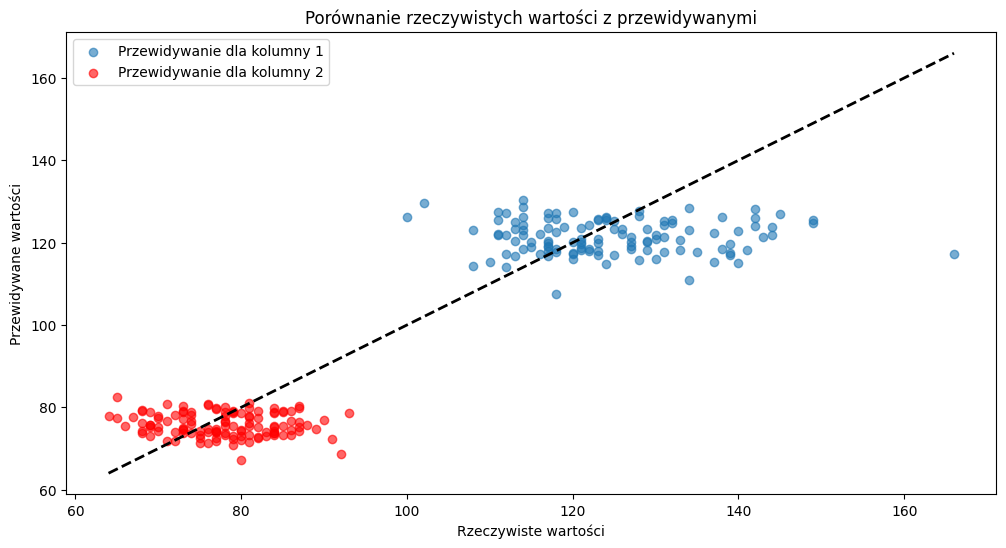

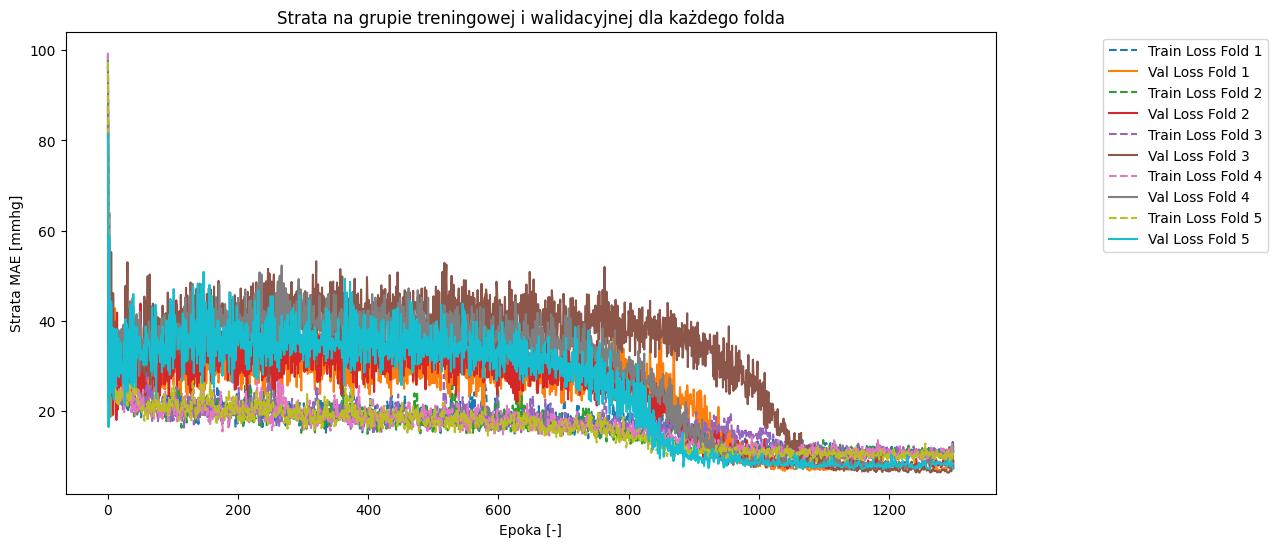

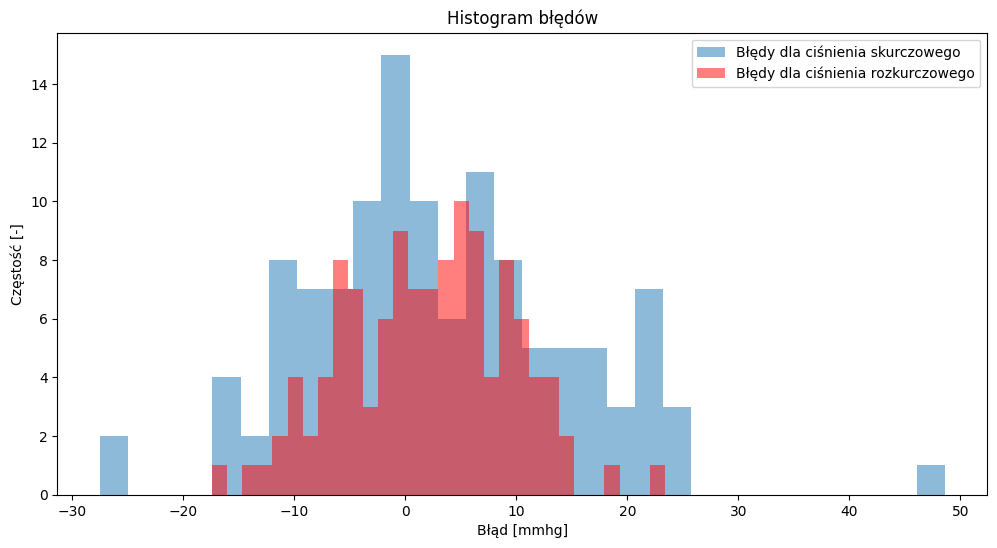

MAE for each fold:
Fold 1: MAE = 7.745
Fold 2: MAE = 8.687
Fold 3: MAE = 7.331
Fold 4: MAE = 8.172
Fold 5: MAE = 7.163

Average MAE: 7.820
Standard Deviation of MAE: 0.557

Percentage of predictions with error less than 5: 21.01%
Percentage of predictions with error less than 10: 54.62%
Percentage of predictions with error less than 15: 78.15%


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pickle

# Load the CSV file
df = pd.read_csv('data_to_model.csv')
df = df.drop(columns=["Filename", "Unnamed: 0"])
print(f"Number of rows before drop: {df.shape[0]}")
df = df.dropna()
print(f"Number of rows after drop: {df.shape[0]}")
# Verify the number of columns
print(f"Number of columns in the dataframe: {df.shape[1]}")

if df.shape[1] == 113:
    print("Window = 0,6")
elif df.shape[1] == 187:
    print("Window = 1")
elif df.shape[1] == 372:
    print("Window = 2")
elif df.shape[1] == 742:
    print("Window = 4")
elif df.shape[1] == 1667:
    print("Window = 9")

# Features and target separation
X = df.iloc[:, :-2].values  # First 740 columns as features
y = df.iloc[:, -2:].values  # Last 2 columns as targets

input_size = int(X.shape[1])

scaler = StandardScaler()
X = scaler.fit_transform(X)

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def create_advanced_model(input_dim):
    # Define a Sequential model
    model = Sequential()
    
    # Add layers to the model
    model.add(Dense(input_dim, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(int(input_dim * 2), activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(int(input_dim * 2), activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(int(input_dim), activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(int(input_dim/2), activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(int(input_dim/4), activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(int(input_dim/8), activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(2, activation='linear'))  # Output layer with 2 neurons for regression
    
    # Compile the model with optimizer, loss function, and metrics
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
    
    return model

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 500 == 0:
            print(f"Epoch {epoch + 1}: loss = {logs['loss']:.4f}, val_loss = {logs['val_loss']:.4f}")

# Initialize variables to store results
train_losses = []
val_losses = []

# List to store MAE scores for each fold
mae_scores = []

# Lists to store predictions and true values
all_y_test = []
all_y_pred = []

for fold_num, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = create_advanced_model(input_size)
    
    # Train the model
    history = model.fit(
        X_train, y_train, 
        epochs=1300, 
        batch_size=32, 
        verbose=0, 
        validation_data=(X_test, y_test),
        callbacks=[CustomCallback()]
    )
    
    # Evaluate the model
    mae = model.evaluate(X_test, y_test, verbose=0)
    mae_scores.append(mae[0])  # Use the loss value which is MAE

    # Append losses to lists
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    
    # Make predictions
    y_pred = model.predict(X_test)
    all_y_test.append(y_test)
    all_y_pred.append(y_pred)

# Concatenate all test sets and predictions
all_y_test = np.concatenate(all_y_test, axis=0)
all_y_pred = np.concatenate(all_y_pred, axis=0)

# Calculate mean and standard error for losses for each epoch
mean_train_loss = np.mean(train_losses, axis=0)
mean_val_loss = np.mean(val_losses, axis=0)

std_val_loss = np.std(val_losses, axis=0)

se_val_loss = std_val_loss / np.sqrt(kf.get_n_splits())

# Plot mean losses with standard error for validation loss
plt.figure(figsize=(12, 6))
plt.plot(mean_train_loss, label='Średnia strata na grupie treningowej')
plt.plot(mean_val_loss, label='Średnia strata na grupie walidacyjnej')
plt.fill_between(range(len(mean_val_loss)), mean_val_loss - se_val_loss, mean_val_loss + se_val_loss, color='gray', alpha=0.2)
plt.xlabel('Epoka [-]')
plt.ylabel('Błąd MAE [mmhg]')
plt.legend()
plt.title('Wykres funkcji straty')
plt.savefig('training_validation_loss_plot.png')
plt.show()

# Plot actual vs predicted values for one fold
plt.figure(figsize=(12, 6))
plt.scatter(all_y_test[:, 0], all_y_pred[:, 0], label='Przewidywanie dla kolumny 1', alpha=0.6)
plt.scatter(all_y_test[:, 1], all_y_pred[:, 1], label='Przewidywanie dla kolumny 2', alpha=0.6, color='r')
plt.plot([all_y_test.min(), all_y_test.max()], [all_y_test.min(), all_y_test.max()], 'k--', lw=2)
plt.xlabel('Rzeczywiste wartości')
plt.ylabel('Przewidywane wartości')
plt.legend()
plt.title('Porównanie rzeczywistych wartości z przewidywanymi')
plt.savefig('predictions_vs_actual.png')
plt.show()

# Plot loss per epoch for each fold
plt.figure(figsize=(12, 6))
for i, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses)):
    plt.plot(train_loss, label=f'Train Loss Fold {i+1}', linestyle='dashed')
    plt.plot(val_loss, label=f'Val Loss Fold {i+1}')
plt.xlabel('Epoka [-]')
plt.ylabel('Strata MAE [mmhg]')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.title('Strata na grupie treningowej i walidacyjnej dla każdego folda')
plt.savefig('loss_per_epoch_each_fold.png')
plt.show()

# Calculate errors
errors = all_y_test - all_y_pred

# Plot error distribution
plt.figure(figsize=(12, 6))
plt.hist(errors[:, 0], bins=30, alpha=0.5, label='Błędy dla ciśnienia skurczowego')
plt.hist(errors[:, 1], bins=30, alpha=0.5, label='Błędy dla ciśnienia rozkurczowego', color='r')
plt.xlabel('Błąd [mmhg]')
plt.ylabel('Częstość [-]')
plt.legend()
plt.title('Histogram błędów')
plt.savefig('error_histogram.png')
plt.show()

# Calculate the percentage of predictions with errors less than 5, 10, and 15
error_magnitude = np.abs(errors)
less_than_5 = np.mean((error_magnitude < 5).all(axis=1)) * 100
less_than_10 = np.mean((error_magnitude < 10).all(axis=1)) * 100
less_than_15 = np.mean((error_magnitude < 15).all(axis=1)) * 100

# Calculate and display mean MAE and standard deviation of MAE
mean_mae = np.mean(mae_scores)
std_mae = np.std(mae_scores)

print("MAE for each fold:")
for fold_num, mae in enumerate(mae_scores, 1):
    print(f"Fold {fold_num}: MAE = {mae:.3f}")

print(f"\nAverage MAE: {mean_mae:.3f}")
print(f"Standard Deviation of MAE: {std_mae:.3f}")

print(f"\nPercentage of predictions with error less than 5: {less_than_5:.2f}%")
print(f"Percentage of predictions with error less than 10: {less_than_10:.2f}%")
print(f"Percentage of predictions with error less than 15: {less_than_15:.2f}%")

# Save the scaler using pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save the MAE scores using pickle
with open('mae_scores.pkl', 'wb') as f:
    pickle.dump(mae_scores, f)

# Save the model using TensorFlow's model.save() method
model.save('model.h5')
